In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Click <a href="javascript:code_toggle()">here</a> to toggle on/off the code.''')


## Project Overview

- As a huge fan of Airbnb, I thought it would be a great idea for me to do a data science related project while attempting to understand how Airbnb is performing in their quest of conquering the China market.

- Luckily, Airbnb releases most of its data on their website - insideairbnb.com, where anyone can have access to their data.

## China Tourism Statistics Overview

![alt text](china_tourist.png "China_Tourist_Analysis")


- Inbound tourism accounts for USD 127.1B
- Domestic tourism accounts for USD 733.3B
- A ratio of 1: 5.77 in 2018 according to 2018 China Tourism Statistics 
<br><br>

<font size="3"> Considering how huge the differences are, it is not surprising that Airbnb China has decided to focus more on localization - establishing brand awareness, building Airbnb community, focusing more on security and trust, and etc.  <br><br>

## Import Libraries & Datasets

In [2]:
# import libraries
%matplotlib inline 

import re
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt

In [3]:
# import datasets

beijing_reviews   = pd.read_csv('beijing_reviews.csv')
hongkong_reviews  = pd.read_csv('hongkong_reviews.csv')
singapore_reviews = pd.read_csv('singapore_reviews.csv')
taipei_reviews    = pd.read_csv('taipei_reviews.csv')
tokyo_reviews     = pd.read_csv('tokyo_reviews.csv')

## Inspect Datasets

In [4]:
beijing_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294003 entries, 0 to 294002
Data columns (total 6 columns):
listing_id       294003 non-null int64
id               294003 non-null int64
date             294003 non-null object
reviewer_id      294003 non-null int64
reviewer_name    293984 non-null object
comments         293815 non-null object
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


In [5]:
beijing_reviews.tail(15)

,listing_id,id,date,reviewer_id,reviewer_name,comments
293988,40270020,567560470,2019-11-22,238667670,周慧娟,"房子很温馨,总体感觉非常棒,离地铁很近,马路对面就是爱琴海,屋内设施很有品质,看的出是很用心..."
293989,40270020,567565895,2019-11-22,271787704,元吉,"这是我第二次过来住了,经常来出差,房子和上次来住的时候一样干净床单被罩都是新换的,特别喜欢房..."
293990,40270020,567565906,2019-11-22,268952012,红梅,来探望高中闺蜜 闺蜜说房间太好赖着不走 吼 结果我们仨挤了一宿 ｡｡｡还好床够大 @@离中医...
293991,40273390,567559337,2019-11-22,311344793,萌,"非常棒的入住体验~家人一直想住四合院体验下,这次出来玩在airbnb上对比了北京很多家这种小..."
293992,40276581,567919194,2019-11-23,311585870,在路上,"整体很不错,房间很暖和,晚上坐在窗边的沙发上观看望京soho是一种享受,房东小姐姐也很热心,..."
293993,40278130,567556919,2019-11-22,119915877,晓月,非常棒 房子很舒服 设计感强 干净 舒适 位置也非常方便出行 强烈推荐啊!
293994,40279657,567568262,2019-11-22,271043957,牡丹,简直超级棒!!相信我这房子比照片还好~超温馨超干净 房东超温柔~简直太好了啊 以后首选!
293995,40279657,567946908,2019-11-23,143661385,书帆,很不错的一次入住体验
293996,40280365,567952989,2019-11-23,258360534,明,"真不错,布置得很好,真的是超出预期,来了才是真切的感受到,房间环境优美,住的很满意!"
293997,40280840,567543915,2019-11-22,59730583,Frank,"很舒服的房间,地理位置也好,房东人也很好,下次还会住这里"


In [6]:
#hongkong_reviews.info()
#singapore_reviews.info()
#taipei_reviews.info()
#tokyo_reviews.info()

## Task 1 - Inspect how much Airbnb China has grown (YoY)

In [7]:
def clean_dataset(dataset):
    '''Clean dataset and return two different dataframes.'''
    
    # drop null values (negligible)
    dataset = dataset[dataset['comments'].notnull() & dataset['reviewer_name'].notnull()]
    
    # we only care about 2018 & 2019
    dataset = dataset[dataset['date'] >= '2018-01-01']
    dataset['year'] = pd.DatetimeIndex(dataset['date']).year
    dataset['month'] = pd.DatetimeIndex(dataset['date']).month
    dataset = dataset.sort_values(by=['date'], ascending=False)
    
    # Anomaly Comments: The host canceled this reservation {} days before...
    dataset['anomaly'] = dataset.comments.str.find('The host canceled this reservation') # return index
    dataset['anomaly'].replace({-1: 1}, inplace=True) # change -1 not found to 1
    print(dataset['anomaly'].value_counts(normalize=True)) # just wanted to figure out what it looks like

    dataset = dataset[dataset['anomaly'] != 0] # drop the anomal, insignificance
    dataset = dataset.drop(columns=['anomaly'])
    dataset = dataset.reset_index(drop=True)
    
    # return groupby dataset for the purpose of graph plotting
    dataset_groupby = dataset.groupby(['year', 'month'])
    dataset_groupby = dataset_groupby['comments'].count()
    dataset_groupby = dataset_groupby.to_frame('count')
    dataset_groupby.reset_index(inplace=True)
    return dataset, dataset_groupby

In [8]:
def plot_graph(dataset_groupby):
    graph = sns.FacetGrid(dataset_groupby, col="year", col_order=[2018, 2019], height=5.5, aspect=1)
    def plot(*args,**kwargs):
        kwargs["data"].plot(kind="bar", x="month", y="count", ax=plt.gca(), color="lightslategray")
    graph.map_dataframe(plot)
    graph.set_xlabels('Months', fontsize=12, ha='center')
    graph.set_ylabels('Comments Count', fontsize=12, ha='center')
    graph.fig.suptitle('Comments Count by Months (2018 VS 2019)', fontsize=14, ha='center')
    plt.subplots_adjust(top=0.89)
    plt.savefig('comments.png')
    plt.show()

In [9]:
# Get an overview on how many anomaly comments 
print('Beijing')
beijing_reviews, beijing_reviews_groupby     = clean_dataset(beijing_reviews)
print('Hong Kong')
hongkong_reviews, hongkong_reviews_groupby   = clean_dataset(hongkong_reviews)
print('Singapore')
singapore_reviews, singapore_reviews_groupby = clean_dataset(singapore_reviews)
print('Taipei')
taipei_reviews, taipei_reviews_groupby       = clean_dataset(taipei_reviews)
print('Tokyo')
tokyo_reviews, tokyo_reviews_groupby         = clean_dataset(tokyo_reviews)

Beijing
1    0.990553
0    0.009447
Name: anomaly, dtype: float64
Hong Kong
1    0.98997
0    0.01003
Name: anomaly, dtype: float64
Singapore
1    0.990054
0    0.009946
Name: anomaly, dtype: float64
Taipei
1    0.997076
0    0.002924
Name: anomaly, dtype: float64
Tokyo
1    0.997194
0    0.002806
Name: anomaly, dtype: float64


Beijing


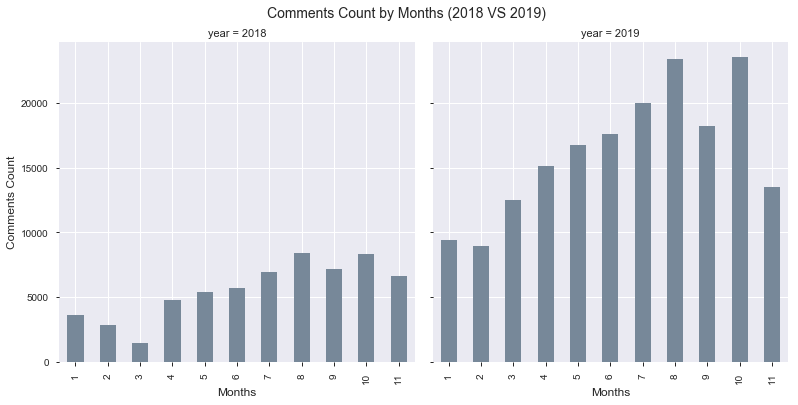

In [10]:
print("Beijing")
plot_graph(beijing_reviews_groupby)

Hong Kong


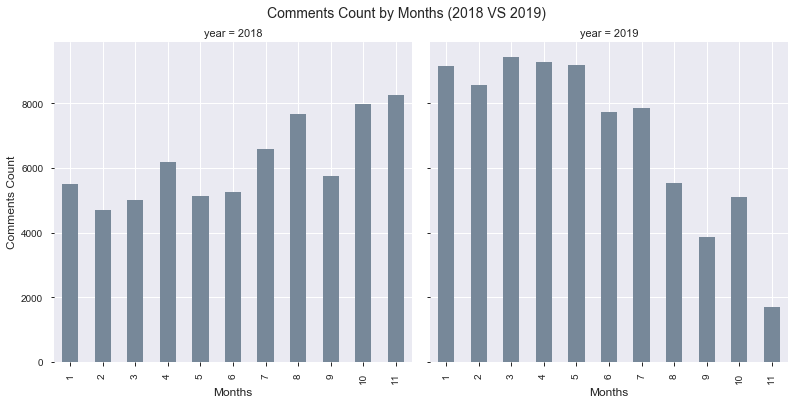

In [11]:
# in comparison with hong kong
# quickly realize that hong kong might not be the best due to the political riot
print("Hong Kong")
plot_graph(hongkong_reviews_groupby)

Singapore


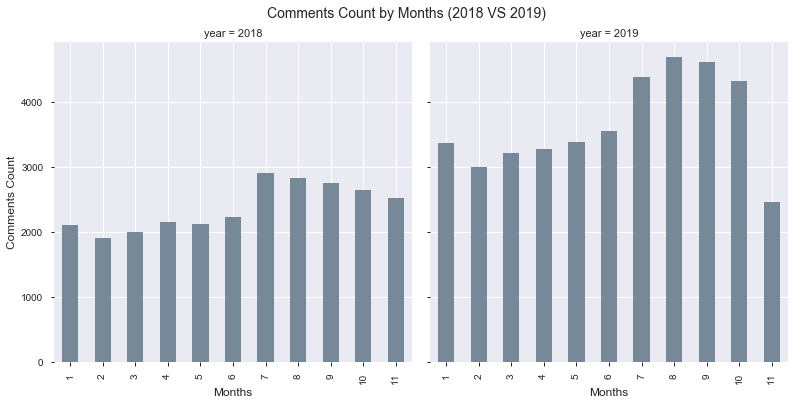

In [12]:
print("Singapore")
plot_graph(singapore_reviews_groupby)

Taipei


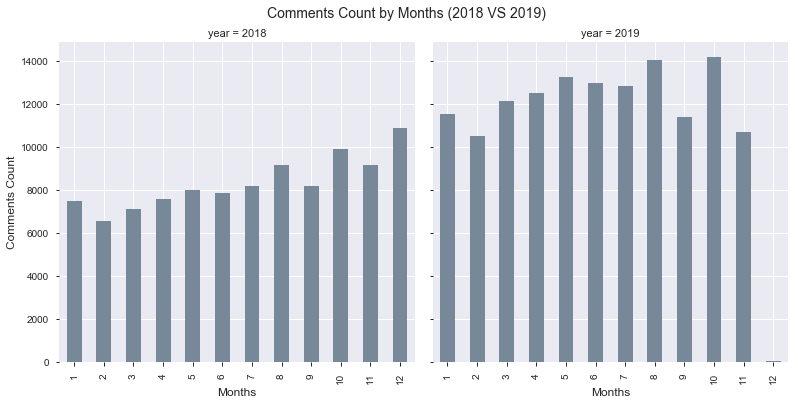

In [13]:
print("Taipei")
plot_graph(taipei_reviews_groupby)

- It's pretty obvious that Airbnb is clearly focusing on expanding the Airbnb China community and it's achieving a significant success.

## Task 2 - Dig Deeper into Airbnb China

- Observation : Different languages in the comment section.
- Assumption  : Users from different countries leave comments using their native language.

In [14]:
def language_detection(texts):
    if re.search("[\u4e00-\u9FFF]", texts):
        return "zh" # Chinese
    if re.search("[\uac00-\ud7a3]", texts) or re.search("[\u3040-\u30ff]", texts):
        return "ko/ja" # Korean / Japanese
    if re.search("[\u0000-\u0080]", texts):
        return "eng" # English
    return "others"

def language_breakdown(name, dataset):
    dataset['language'] = dataset['comments'].apply(language_detection)
    dataset = dataset[dataset['language'] != "others"]
    dataset = dataset.reset_index(drop=True)
    print(dataset['language'].value_counts())
    dataset_groupby_language = dataset.groupby(['year', 'month', 'language']).comments.count()
    dataset_groupby_language = dataset_groupby_language.to_frame('count')
    dataset_groupby_language = pd.pivot_table(dataset_groupby_language, index=['year', 'month'], columns=['language'],fill_value=0)
    dataset_groupby_language.to_csv(str(name + "_language.csv"))

In [15]:
print("Beijing: ")
print(language_breakdown('beijing', beijing_reviews))
print("\nHong Kong: ")
print(language_breakdown('hongkong', hongkong_reviews))
print("\nSingapore: ")
print(language_breakdown('singapore', singapore_reviews))
print("\nTaipei: ")
print(language_breakdown('taipei', taipei_reviews))
print("\nTokyo: ")
print(language_breakdown('tokyo', tokyo_reviews))

Beijing: 
zh       227713
eng       19969
ko/ja       595
Name: language, dtype: int64
None

Hong Kong: 
eng      82156
zh       67260
ko/ja     4485
Name: language, dtype: int64
None

Singapore: 
eng      60118
zh        8107
ko/ja     1136
Name: language, dtype: int64
None

Taipei: 
zh       131150
eng       94956
ko/ja     10120
Name: language, dtype: int64
None

Tokyo: 
eng      192803
zh        79687
ko/ja     13052
Name: language, dtype: int64
None


- So, if we were to look closely at those numbers, we will quickly realize that Beijing comes in last place when it comes to a combination of both (English + Korean/Japanese) comments. ~20K in combination, while the rest of the countries has more than 60K at least. <br><br>

- Decided to just use Hong Kong and Taiwan in comparison with Beijing due to the similarity in demographic.

In [16]:
# Construct 2 simple CSV files based on the new files that we've created.

chinese_2019 = pd.read_csv("chinese_comments.csv", index_col='Month')
foreign_2019 = pd.read_csv("foreign_comments.csv", index_col='Month')

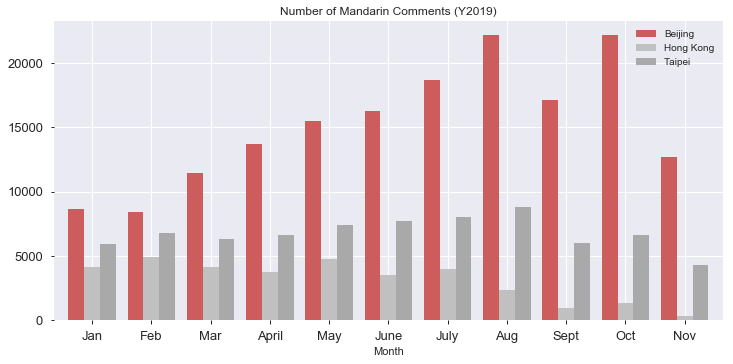

In [17]:
colors = ['indianred', 'silver', 'darkgray']
plt_chinese = chinese_2019.plot.bar(align='center', color=colors, \
                                    figsize=(12,5.5), rot=0, width=0.8,fontsize=13, \
                                    title="Number of Mandarin Comments (Y2019)")

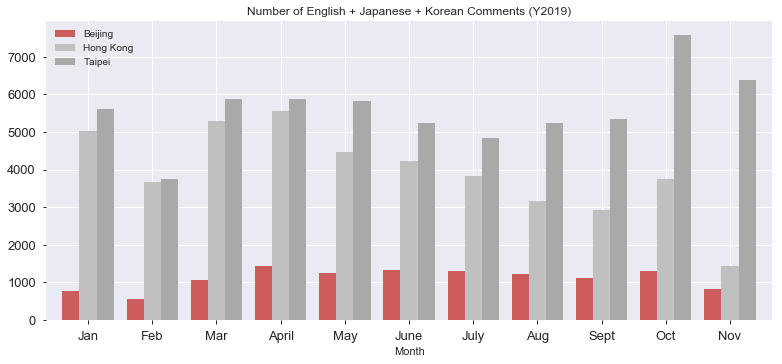

In [18]:
plt_foreign = foreign_2019.plot.bar(align='center', color=colors, \
                                    figsize=(13,5.5), rot=0, width=0.8, fontsize=13, \
                                    title="Number of English + Japanese + Korean Comments (Y2019)")